<a href="https://colab.research.google.com/github/Horcruxno13/IMDB-Sentiment-Analysis/blob/main/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Reviews Sentiment Analysis
## Introduction
Sentiment analysis, a subfield of Natural Language Processing (NLP), is the task of determining the emotional tone behind a piece of text. In recent years, sentiment analysis has gained tremendous popularity as it enables businesses to understand their customers' opinions and reactions towards their products and services. In this project, we aim to perform sentiment analysis on IMDb reviews, a popular online database of movies and TV shows. The dataset was obtained from Kaggle. We will use Long Short Term Memory (LSTM) for our neural network and NLP techniques to classify the reviews into positive or negative categories.

## 1. Exploratory Data Analysis
### 1.1 Importing the necessary libraries|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, punkt
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/Datasets/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### 1.2 Transforming the sentiment value to numbers 

In [4]:
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [5]:
data['token_length'] = data['review'].apply(lambda x: len(x.split()))

In [6]:
data_pos = data[data['sentiment'] == 1]
data_neg = data[data['sentiment'] == 0]

### 1.3 Plotting the length of the reviews based on sentiment

<Figure size 360x576 with 0 Axes>

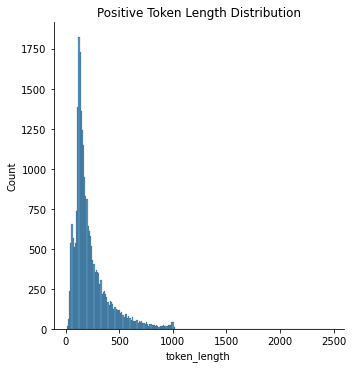

In [7]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 360x576 with 0 Axes>

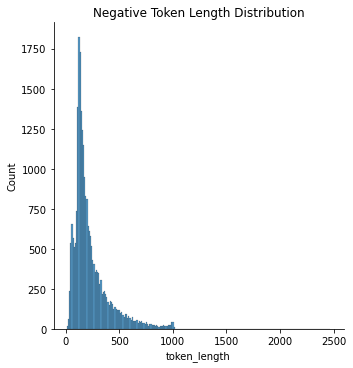

In [8]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

## 2. Cleaning and Preprocessing Pipeline
### 2.1 Removing links, punctuation, numbers, emojis, etc.

In [9]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)
    s = re.sub(r'\s{2,}', ' ', s)    
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

In [10]:
def clean_pipeline(text):    
    no_link = rm_link(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

### 2.2 Tokenisation, stopwords and lemmatisation

In [11]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()    
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    return rm_stopwords(lemmas)

In [12]:
def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [13]:
data['review'] = data['review'].apply(clean_pipeline)
data['review'] = data['review'].apply(preprocess_pipeline)

In [14]:
data.head()

,review,sentiment,token_length
0,One reviewer mentioned watching Oz episode hoo...,1,307
1,A wonderful little production . The filming te...,1,162
2,I thought wonderful way spend time hot summer ...,1,166
3,Basically family little boy Jake think zombie ...,0,138
4,Petter Mattei Love Time Money visually stunnin...,1,230


## 3. Preparing data for modelling
### 3.1 Building a vocabulary

In [15]:
reviews = data['review'].values

In [16]:
words = ' '.join(reviews)
words = words.split()

In [17]:
len(words)

7888384

In [18]:
from collections import Counter
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [19]:
len(word2int)

121301

In [20]:
reviews_enc = [[word2int[word] for word in review.split()] for review in reviews]

### 3.2 Creating sequences of the same length by padding

In [21]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]
    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

In [22]:
labels = data['sentiment'].to_numpy()

## 4. Training and testing the model
### 4.1 Creating training, validation and testing set

In [23]:
train_size = .7     
val_size = .5

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

print('Feature Shapes:')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [24]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

### 4.2 Loading the dataset

In [25]:
batch_size = 128

trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [27]:
dataiter = iter(trainloader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[ 9642,     3,    44,  ...,     0,     0,     0],
        [ 5113,  1365,   766,  ...,     0,     0,     0],
        [24938,   905,    32,  ...,     0,     0,     0],
        ...,
        [ 1846,     2,   482,  ...,     0,     0,     0],
        [    3,   319,   231,  ...,     0,     0,     0],
        [68391,   363,   774,  ...,     0,     0,     0]])

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1])


### 4.3 Building the neural network architecture

In [28]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ =  self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)
        return o

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 4.4 Defining the parameters

In [30]:
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.25
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)

In [31]:
lr = 0.001
criterion = nn.BCELoss() 
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 8
print_every = 1
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epochs': epochs}
es_limit = 5

### 4.5 Training & Validation

In [32]:
model = model.to(device)
epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:
    model.train()
    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')
        feature, target = feature.to(device), target.to(device)
        optim.zero_grad()
        out = model(feature)
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optim.step()
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))
    
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            feature, target = feature.to(device), target.to(device)
            out = model(feature)
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    model.train()

    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history['epochs'] = e+1
        break

Training:  12%|█▎        | 1/8 [01:08<08:01, 68.74s/it, Val Loss: 0.695 | Val Acc: 0.503]

Epoch 1/8 | Train Loss: 0.697 Train Acc: 0.503 | Val Loss: 0.695 Val Acc: 0.503


Training:  38%|███▊      | 3/8 [02:19<03:58, 47.77s/it, Val Loss: 0.693 | Val Acc: 0.500]

Epoch 2/8 | Train Loss: 0.695 Train Acc: 0.503 | Val Loss: 0.693 Val Acc: 0.500


Training:  50%|█████     | 4/8 [03:30<03:48, 57.00s/it, Val Loss: 0.693 | Val Acc: 0.507]

Epoch 3/8 | Train Loss: 0.695 Train Acc: 0.497 | Val Loss: 0.693 Val Acc: 0.507


Training:  75%|███████▌  | 6/8 [04:41<01:36, 48.17s/it, Training batch 0/274]            

Epoch 4/8 | Train Loss: 0.690 Train Acc: 0.513 | Val Loss: 0.701 Val Acc: 0.562
[WARNING] Validation loss did not improved (0.693 --> 0.701)


Training:  88%|████████▊ | 7/8 [05:52<00:55, 55.54s/it, Val Loss: 0.554 | Val Acc: 0.691]

Epoch 5/8 | Train Loss: 0.597 Train Acc: 0.656 | Val Loss: 0.554 Val Acc: 0.691


Training: 100%|██████████| 8/8 [07:03<00:00, 60.57s/it, Val Loss: 0.487 | Val Acc: 0.744]

Epoch 6/8 | Train Loss: 0.453 Train Acc: 0.765 | Val Loss: 0.487 Val Acc: 0.744


Training: 10it [08:15, 50.78s/it, Training batch 0/274]            

Epoch 7/8 | Train Loss: 0.401 Train Acc: 0.788 | Val Loss: 0.506 Val Acc: 0.741
[WARNING] Validation loss did not improved (0.487 --> 0.506)


Training: 11it [09:26, 56.92s/it, Val Loss: 0.373 | Val Acc: 0.858]

Epoch 8/8 | Train Loss: 0.304 Train Acc: 0.881 | Val Loss: 0.373 Val Acc: 0.858


Training: 100%|██████████| 8/8 [09:26<00:00, 70.82s/it, Val Loss: 0.373 | Val Acc: 0.858]


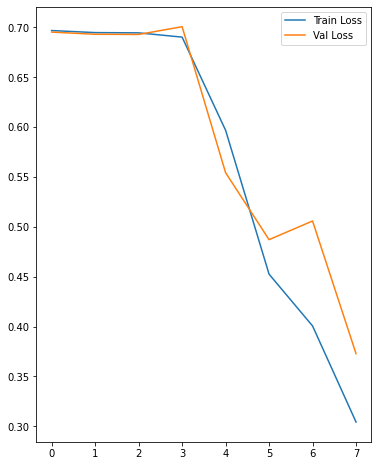

In [33]:
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

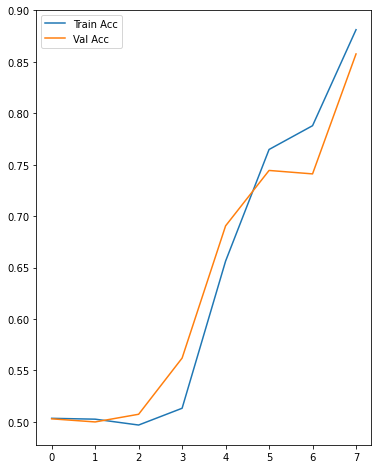

In [34]:
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

### 4.6 Testing the model

In [35]:
model.eval()
test_loss = 0
test_acc = 0
all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)
        
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference: 100%|██████████| 59/59 [00:04<00:00, 12.26it/s]

Accuracy: 0.8541, Loss: 0.3770


## Conclusion
In conclusion, our sentiment analysis project on IMDb reviews has achieved a high accuracy score of 85.41%, demonstrating the effectiveness of NLP techniques and neural networks in classifying sentiments. The project's outcome provides valuable insights into the sentiment of IMDb users towards different movies and TV shows. With the continuous growth of data and advances in NLP technology, sentiment analysis will become increasingly vital in understanding customer opinions and preferences.